# Simple Music Signal Spectral Analysis

In [1]:
import doctest
from pathlib import Path

import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sklearn
import soundfile as sf
from IPython.display import Audio

In [2]:
def check_versions(tested_modules):
    df = pd.DataFrame(tested_modules.items(), columns=["m", "Tested"])
    df["Module"] = df.m.map(lambda m: m.__name__)
    df["Current"] = df.m.map(lambda m: m.__version__)
    df = df.set_index("Module").drop(columns=["m"]).query("Tested != Current")
    if not df.empty:
        display(df)

In [3]:
check_versions(
    {
        pd: "2.2.1",
        sklearn: "1.4.1.post1",
        mpl: "3.8.3",
        sns: "0.13.2",
        librosa: "0.10.1",
    }
)

In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

pd.set_option("display.float_format", "{:.4f}".format)

sns.set_style("darkgrid")
sns.set_context("notebook")

plt.rcParams["font.family"] = "DejaVu Sans"  # Glyph 9837 (♭) missing from font

In [5]:
DATA = Path("data")

In [6]:
FS = 48_000
N_FFT = 1024
WIN_LENGTH = int(FS * 30e-3)
HOP_LENGTH = int(FS * 10e-3)  # int(FS * 20e-3)
N_MELS = 128
N_MFCC = 13
N_FILES = 1596
KEY = "Eb:maj"

print(f"Window length: {WIN_LENGTH}, hop length: {HOP_LENGTH}")

Window length: 1440, hop length: 480


In [7]:
def eps(xs):
    return np.finfo(xs.dtype).eps

In [8]:
def print_prec(x, prec=5, mode="g"):
    print(f"{x:.{prec}{mode}}")

In [9]:
def key_to_scale(key):
    """
    Note: will be sufficient when for Librosa 0.10.2
    >>> key_to_scale("C:min")
    ['C', 'D', 'E♭', 'F', 'G', 'A♭', 'B♭']
    """
    degs = librosa.key_to_degrees(key)
    return np.array(librosa.key_to_notes(key))[degs].tolist()

In [10]:
def format_alteration(s):
    """
    >>> format_alteration("Eb")
    'E♭'
    >>> format_alteration("A#")
    'A♯'
    """
    return s.replace("b", "♭").replace("#", "♯")

In [11]:
def chord_to_arpeggio(chord, key="C:maj"):
    """
    >>> chord_to_arpeggio("C:maj", key="C:maj")
    ['C', 'E', 'G']
    >>> chord_to_arpeggio("E:min7b5", key="F:maj")
    ['E', 'G', 'B♭', 'D']
    """
    forms = {
        "maj": [0, 4, 7],
        "min": [0, 3, 7],
        "maj7": [0, 4, 7, 11],
        "min7": [0, 3, 7, 10],
        "7": [0, 4, 7, 10],
        "min7b5": [0, 3, 6, 10],
        "dim": [0, 3, 6],
        "aug": [0, 4, 8],
    }  # TODO: Add 9 and 11, sus2 and sus4, etc.
    tone, form = chord.split(":")
    notes = librosa.key_to_notes(key)
    order = notes.index(format_alteration(tone))
    notes = np.array(notes[order:] + notes[:order])
    return notes[forms[form]].tolist()

In [12]:
def make_notes(
    start_m,
    n_octs,
    chord="C:maj",
    key="C:maj",
    freq=False,
    format_notes=False,
    arr=None,
):
    midi_notes = [m for m in range(start_m, start_m + n_octs * 12 + 1)]
    notes = librosa.midi_to_note(midi_notes, key=key)
    if arr is not None:
        scale = key_to_scale(key)
        if arr == "scale":
            notes = [n for n in notes if n[:-1] in scale]
        elif arr == "arpeggio":
            arpeggios = chord_to_arpeggio(chord, key=key)
            notes = [n for n in notes if n[:-1] in arpeggios]

    fmt_notes = [n if "C" in n else n[:-1] for n in notes] if format_notes else notes

    if freq:
        freqs = [librosa.note_to_hz(n) for n in notes]
        return fmt_notes, freqs

    return fmt_notes

In [13]:
def measure_spectrum(xs, fs, fft_os=1, freq=False):
    n_fft = 2 ** int(np.ceil(np.log2(len(xs) * fft_os)))
    win = sp.signal.get_window("hann", len(xs))
    spec_xs = np.abs(np.fft.rfft(xs * win, n=n_fft))
    spec_xs = librosa.amplitude_to_db(spec_xs, ref=np.max)
    freq_xs = np.fft.rfftfreq(n=n_fft, d=1 / fs)
    if freq:
        return spec_xs, freq_xs
    return spec_xs

In [14]:
def plot_spectrum(xs, fs, chord="C:maj", key="C:maj", fft_os=1):
    spec_xs, freq_xs = measure_spectrum(xs, fs, fft_os, freq=True)
    notes, freqs = make_notes(
        36,
        n_octs=4,
        chord=chord,
        key=key,
        freq=True,
        format_notes=True,
        arr="arpeggio",
    )
    plt.figure(figsize=(8, 2))
    plt.plot(freq_xs, spec_xs)
    plt.xscale("log")
    plt.xlim(50, 1100)
    plt.ylim(-65, None)
    plt.xticks(ticks=freqs, labels=notes)  # type: ignore
    plt.xticks(fontsize=9)  # rotation=60
    plt.show()

In [15]:
def get_list(chord):
    """
    >>> chords = pd.Series(["C3", "C4?", "Eb4", "G4", "C5?"])
    >>> get_list(chords)
    ['C3', 'C4', 'Eb4', 'G4', 'C5']
    """
    return chord.str.strip("?").to_list()

---

In [16]:
doctest.testmod()

TestResults(failed=0, attempted=7)

---

In [17]:
# xs, fs = sf.read(fp)
# xs = xs.mean(axis=1)  # Convert to mono
# print(xs.shape, xs.dtype, fs)
# print_prec(xs.std())

In [18]:
# sample_xs = xs[2000:360_000]
# # save sample to file
# sf.write(DATA / "Niemand-sample.wav", sample_xs, fs)

In [19]:
xs, fs = sf.read(DATA / "Niemand-sample.wav")

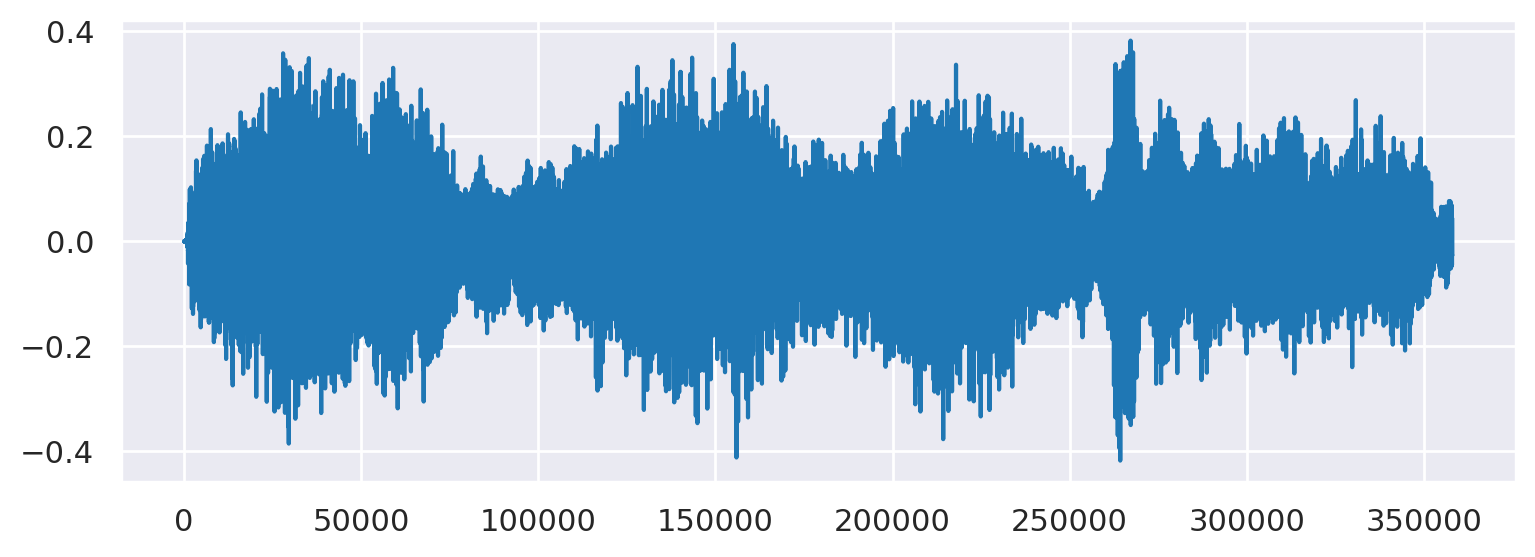

In [20]:
plt.figure(figsize=(9, 3))
plt.plot(xs)
plt.show()

In [21]:
Audio(xs, rate=FS)

In [22]:
STARTS = [10_000, 140_000, 220_000, 300_000, 340_000]
LEN = 10_000
chord_xs_lst = [xs[start : start + LEN] for start in STARTS]

In [23]:
for chord_xs in chord_xs_lst:
    display(Audio(chord_xs, rate=FS))

In [24]:
notes, freqs = make_notes(
    36, n_octs=4, chord="F:min7", key="Eb:maj", freq=True, arr="arpeggio"
)
notes_df = pd.DataFrame({"Note": notes, "Frequency": freqs})
notes_df

,Note,Frequency
0,C2,65.4064
1,E♭2,77.7817
2,F2,87.3071
3,A♭2,103.8262
4,C3,130.8128
5,E♭3,155.5635
6,F3,174.6141
7,A♭3,207.6523
8,C4,261.6256
9,E♭4,311.1270


In [25]:
chord_notes_d = {
    "C:min": ["C3", "C4", "Eb4", "G4"],
    "F:min7": ["F2", "F3", "Ab3", "C4", "Eb4"],
    "Eb:maj": ["G2", "G3", "Bb3", "Eb4", "G4"],
    "Ab:maj": ["Ab2", "Ab3", "C4", "Eb4", "Ab4"],
    "D:min7b5": ["Ab2", "Ab3", "C4", "F4", "C5", "D5", "F5"],
}

In [26]:
for chord in chord_notes_d:
    print(chord_to_arpeggio(chord, key="Eb:maj"))

['C', 'E♭', 'G']
['F', 'A♭', 'C', 'E♭']
['E♭', 'G', 'B♭']
['A♭', 'C', 'E♭']
['D', 'F', 'A♭', 'C']


In [27]:
# format all alterations in the chord_notes_d dictionary
chord_notes_d = {
    chord: [format_alteration(n) for n in played_notes]
    for (chord, played_notes) in chord_notes_d.items()
}
chords = [pd.Series(chord_notes_d[chord], name=chord) for chord in chord_notes_d]
print(*chords[0].str.strip("?"))

C3 C4 E♭4 G4


In [28]:
chord_notes_df = pd.DataFrame()
for chord in chords:
    chord_notes_df[chord.name] = pd.Series(
        make_notes(36, n_octs=4, key=KEY, arr="scale")
    )
chord_notes_df.head()

,C:min,F:min7,Eb:maj,Ab:maj,D:min7b5
0,C2,C2,C2,C2,C2
1,D2,D2,D2,D2,D2
2,E♭2,E♭2,E♭2,E♭2,E♭2
3,F2,F2,F2,F2,F2
4,G2,G2,G2,G2,G2


C:min:  C3 C4 E♭4 G4


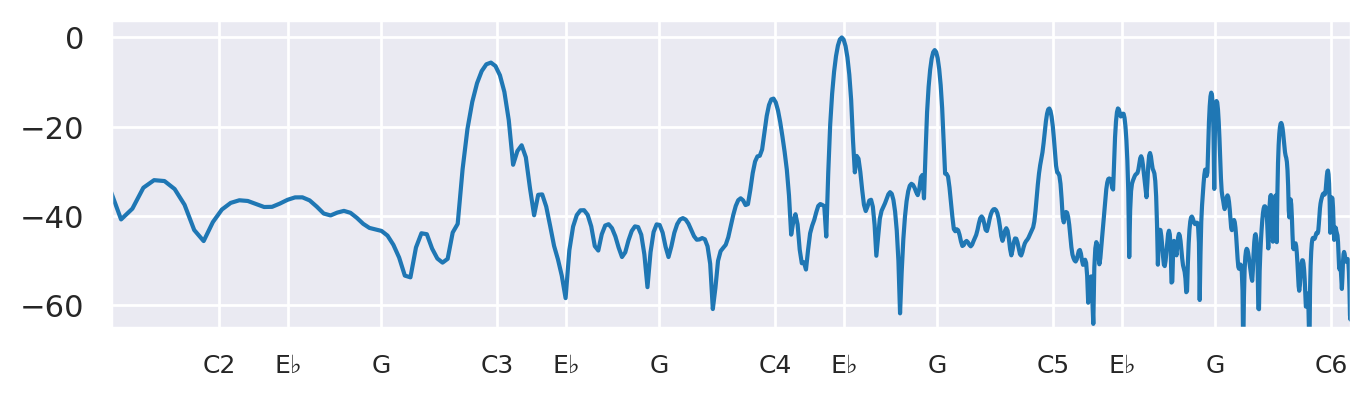

F:min7:  F2 F3 A♭3 C4 E♭4


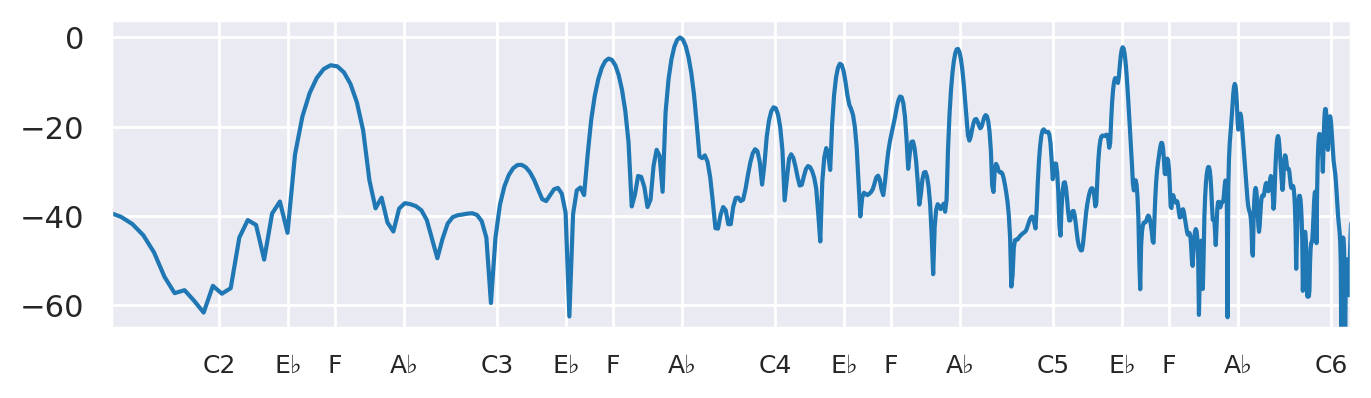

Eb:maj:  G2 G3 B♭3 E♭4 G4


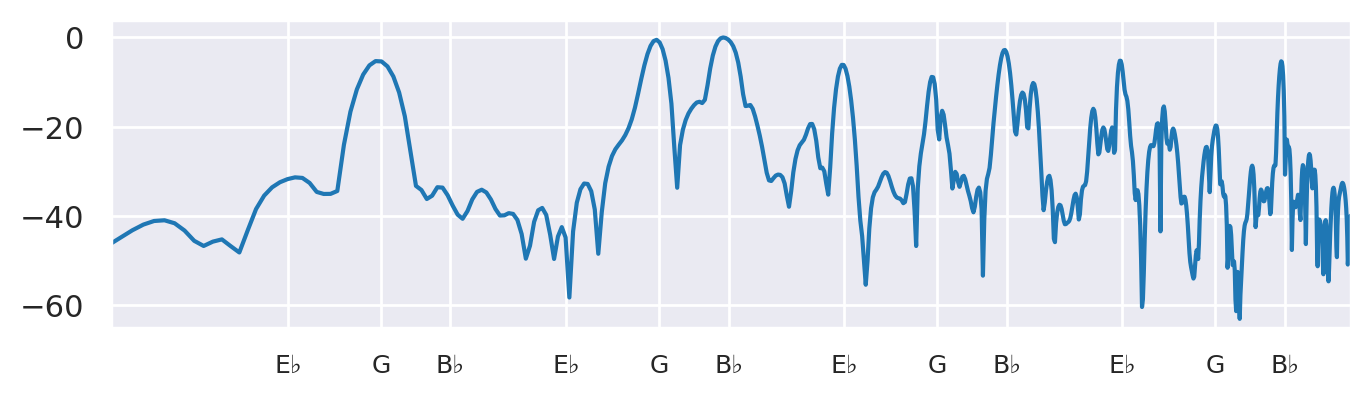

Ab:maj:  A♭2 A♭3 C4 E♭4 A♭4


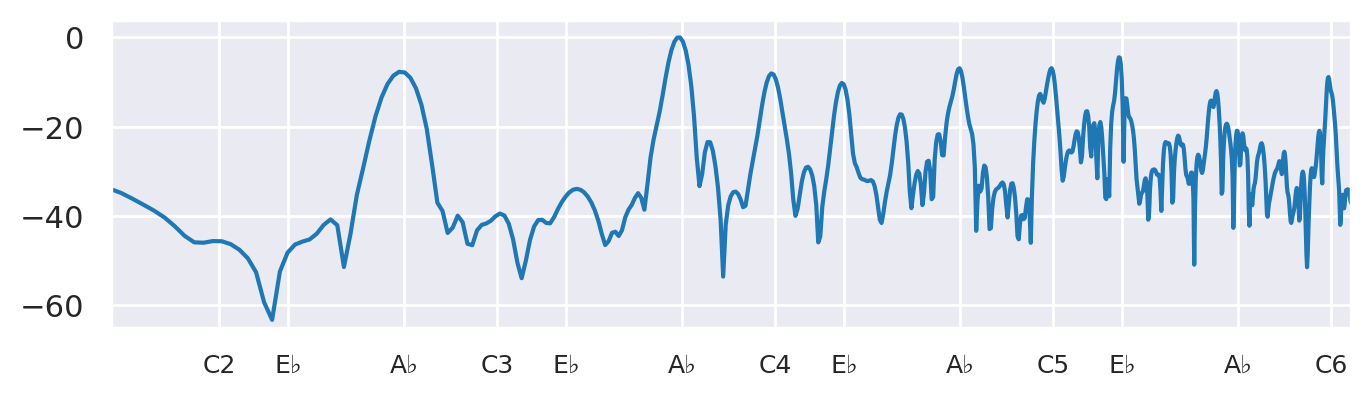

D:min7b5:  A♭2 A♭3 C4 F4 C5 D5 F5


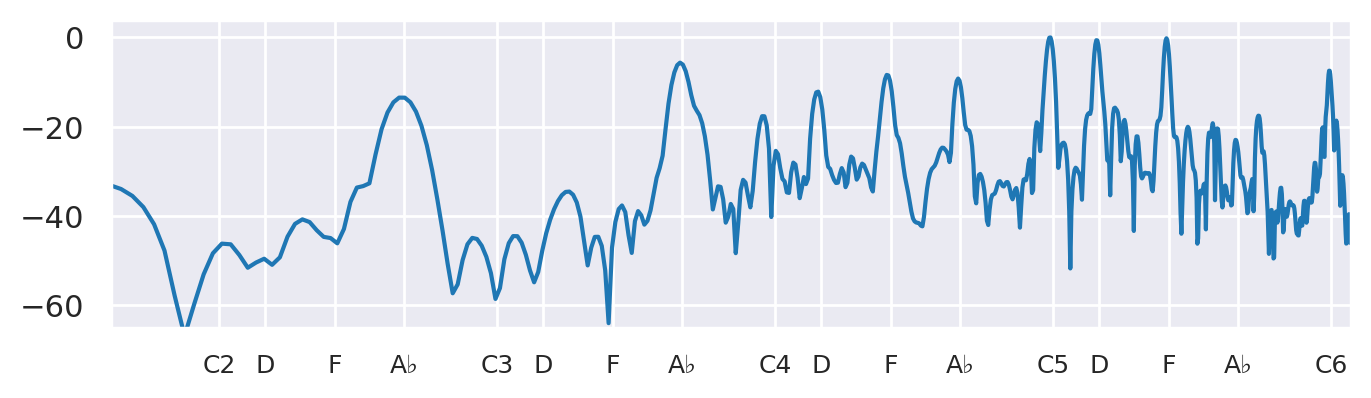

In [29]:
for chord_xs, chord in zip(chord_xs_lst, chords):
    print(f"{chord.name}: ", *chord)
    plot_spectrum(chord_xs, FS, chord=chord.name, key=KEY, fft_os=2)  # type: ignore

In [30]:
styled_df = chord_notes_df.style.apply(
    lambda df: np.where(df.isin(chord_notes_d), "background-color: yellow", ""),
    axis=None,
)
styled_df.to_html(DATA / "Niemand-chord_notes.html")
styled_df

,C:min,F:min7,Eb:maj,Ab:maj,D:min7b5
0,C2,C2,C2,C2,C2
1,D2,D2,D2,D2,D2
2,E♭2,E♭2,E♭2,E♭2,E♭2
3,F2,F2,F2,F2,F2
4,G2,G2,G2,G2,G2
5,A♭2,A♭2,A♭2,A♭2,A♭2
6,B♭2,B♭2,B♭2,B♭2,B♭2
7,C3,C3,C3,C3,C3
8,D3,D3,D3,D3,D3
9,E♭3,E♭3,E♭3,E♭3,E♭3


---